In [1]:
!pip install tensorflow

In [2]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import ops
from keras.layers import Resizing
import tensorflow as tf
import tensorflow_datasets as tfds

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech101/incomplete.5WYIJ1_3.0.2/caltech101-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech101/incomplete.5WYIJ1_3.0.2/caltech101-test.tfrecord*...:   0%|    …

Dataset caltech101 downloaded and prepared to /root/tensorflow_datasets/caltech101/3.0.2. Subsequent calls will reuse this data.


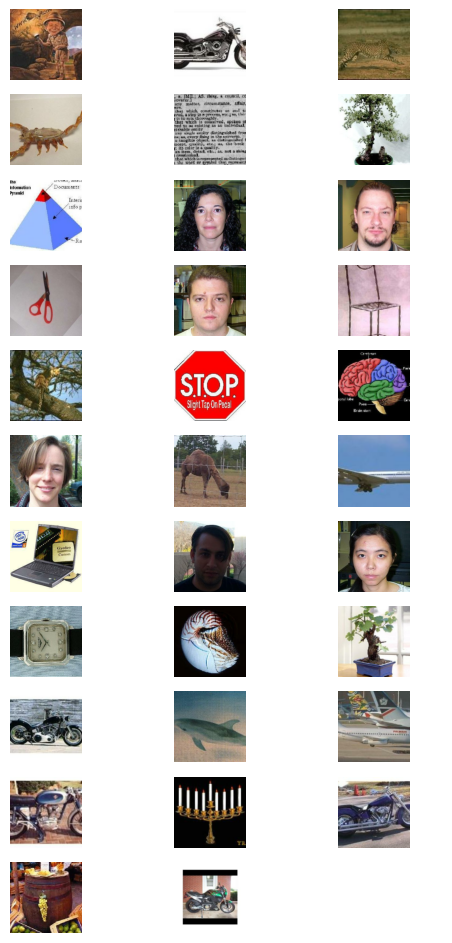

In [3]:
# Set backend
os.environ["KERAS_BACKEND"] = "jax"

# Constants
BATCH_SIZE = 32
NUM_CLASSES = 101
IMAGE_SIZE = (224, 224)

# Function to plot images
def plot_image_gallery(images, titles=None, num_cols=3, figsize=(6, 12)):
    num_images = len(images)
    images = np.asarray(images) / 255.0
    images = np.minimum(np.maximum(images, 0.0), 1.0)
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, squeeze=False)
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(images[i])
            ax.axis("off")
            if titles and len(titles) > i:
                ax.set_title(titles[i], fontsize=12)
        else:
            ax.axis("off")
    plt.show()
    plt.close()

# Load and preprocess dataset
def package_inputs(image, label):
    return {"images": image, "labels": tf.one_hot(label, NUM_CLASSES)}

train_ds, eval_ds = tfds.load(
    "caltech101", split=["train", "test"], as_supervised=True
)
train_ds = train_ds.map(package_inputs, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(package_inputs, num_parallel_calls=tf.data.AUTOTUNE)

# Resize for inference
inference_resizing = Resizing(*IMAGE_SIZE, crop_to_aspect_ratio=True)

def do_resize(inputs):
    inputs["images"] = inference_resizing(inputs["images"])
    return inputs

eval_ds = eval_ds.map(do_resize, num_parallel_calls=tf.data.AUTOTUNE)

# Visualize resized images
image_batch = next(iter(eval_ds.batch(BATCH_SIZE).take(1)))["images"]
plot_image_gallery(image_batch)

# Unpackage dictionary into tuples
def unpackage_dict(inputs):
    return inputs["images"], inputs["labels"]

train_ds = train_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)

# Learning rate scheduler
def lr_warmup_cosine_decay(
    global_step,
    warmup_steps,
    hold=0,
    total_steps=0,
    start_lr=0.0,
    target_lr=1e-2,
):
    learning_rate = (
        0.5
        * target_lr
        * (
            1
            + ops.cos(
                math.pi
                * ops.convert_to_tensor(global_step - warmup_steps - hold, dtype="float32")
                / ops.convert_to_tensor(total_steps - warmup_steps - hold, dtype="float32")
            )
        )
    )

    warmup_lr = target_lr * (global_step / warmup_steps)

    if hold > 0:
        learning_rate = ops.where(
            global_step > warmup_steps + hold, learning_rate, target_lr
        )
    else:
        learning_rate = ops.where(
            global_step > warmup_steps, learning_rate, warmup_lr
        )

    learning_rate = ops.where(
        global_step > total_steps, 0.0, learning_rate
    )
    return learning_rate
